**Important! Please do not remove any cells, including the test cells, even if they appear empty. They contain hidden tests, and deleting them could result in a loss of points, as the exercises are graded automatically. Only edit the cells where you are instructed to write your solution.**

# Exercise 3

## Task 4: Regularization Practices (5 Points)

In Task 2 you have tried differnt hyperparameter tuning techniques to increase the performance of the model on the training set. In this task, you will practice regularization techniques to help the model to generalize to unseen data, i.e., to increase the performance on the validation set. You are asked to start with a model that achieves a good performance on the training set compared to the base model. However, the number of trainable parameters in this model is large which leads to over-fitting as observed in the training and validation curves. Here we try different techniques to decreadse the number of trainable påarameters and to increase the model performance on validation set. 


### Summary of Tasks for This Stage


**Task 4.1: Experiment with normalization layers** (1 point)

    Goal: Observe the effect of batch normalization in model generalization and training stability.

**Task 4.2: Experiment with dropout layers** (1 point)

    Goal: Observe the effect of dropout layers in model generalization.

**Task 4.3: Experiment with efficient model architecture through pooling layers** (3 point)

    Goal: Observe the effect of efficient model design through adjusting receptive field of layers.


### Deliverables from this task:

* ex3_04_regularization.ipynb
* 'normalized_model.pth'
* 'pooled_model.pth'


In [1]:
skip_training = False   # You can set it to True if you want to run inference on your trained model. 

In [2]:
# Do not delete this cell

In [3]:
import librosa
import os
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
import random

# Set random seeds for all libraries
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed(1)
torch.cuda.manual_seed_all(1) 

# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Add the data path

In [5]:
path = "dataset_ex3" # you can change the path if you want to store the dataset somewhere else.

In [6]:
# Do not delete this cell

In [7]:
def prepare_file_list(path, validation_split):
    
    audio_class_names = ['music', 'speech']
    data_directories = {'music': path + '/music_wav', 
                        'speech': path + '/speech_wav'}
    
    audio_files = {class_name: [] for class_name in audio_class_names}
    for class_name in audio_class_names:
        folder = data_directories[class_name]
        filelist = os.listdir(folder)
        for filename in filelist:
            if filename.endswith('.wav'):
                audio_files[class_name].append(os.path.join(folder, filename))
       
    np.random.seed(1)
    dataset_split = {'train': [], 'val': []}
    for class_id, class_name in enumerate(audio_class_names):
        n_data = len(audio_files[class_name])
        random_indices = np.random.permutation(n_data)
        n_validation = int(validation_split * n_data)
        val_indices = random_indices[:n_validation]
        train_indices = random_indices[n_validation:]
        dataset_split['train'] += [(audio_files[class_name][k], class_id) for k in train_indices] 
        dataset_split['val'] += [(audio_files[class_name][k], class_id) for k in val_indices] 
    return dataset_split

In [8]:
class MSDataset(torch.utils.data.Dataset):
    
    def __init__(self, filelist, sample_sec=5., is_train=True):
        self.filelist = filelist
        self.time_duration = sample_sec
        self.is_train = is_train
        
        _, sf = librosa.load(filelist[0][0], sr = None)
        self.sf = sf
        self.n_features = int(self.time_duration * sf)
        
    def __len__(self):
        return len(self.filelist)
    
    def __getitem__(self, i):
        audio_file, class_id = self.filelist[i]
        x, sf = librosa.load(audio_file, sr = None)
        k = 0
            
        x = torch.from_numpy(x[k:k+self.n_features]).reshape(1,-1)
        
        return x, class_id

### Training and validation loops: 

Fill in the blanks as instructed in the code.

**Hint:** Replace the next cell with the training and validation loops from your solution to Task 1 in the ex3_01_base_model.ipynb file.

In [9]:
def training_loop(n_epochs, optim, model, loss_fn, dl_train, dl_val, hist=None):
    np.random.seed(1)
    if hist is not None:
        pass
    else:
        hist = {'train_loss': [], 'train_accuracy': [], 'val_loss': [], 'val_accuracy': []}
    
    best_accuracy = 0
    t_initial = time.time()
    
    for epoch in range(1, n_epochs + 1):
        start = time.time()
        train_loss, train_accuracy = 0., 0.
        num_samples = 0
        
        for input_batch, target_batch in dl_train: 
            # your code here for minibatch training
            # 1. call batch data and labels and set them to the correct device
            # 2. make the prediction on the data
            # 3. calculate loss
            # 4. set optimizer to zero grad
            # 5. do backward pass
            # 6. move the optimizer one step forward
            # YOUR CODE HERE
            input_batch = input_batch.to(device)
            target_batch = target_batch.to(device)

            predictions = model(input_batch)
            loss_train = loss_fn(predictions, target_batch)

            optim.zero_grad()
            loss_train.backward()
            optim.step()
            
            # accumulate correct prediction
            train_accuracy += (torch.argmax(predictions.detach(), dim=1) == target_batch).sum().item() # number of correct predictions
            train_loss += loss_train.item() * input_batch.shape[0]
            num_samples += input_batch.shape[0]
        
        train_loss /= num_samples
        train_accuracy /= num_samples       
        val_loss, val_accuracy = validation_loop(model, loss_fn, dl_val)
        
        end = time.time()
        epoch_time = round(end - start, 2)
        if epoch <= 5 or epoch % 10 == 0 or epoch == n_epochs:
             print(f'Epoch {epoch}, train_loss {train_loss:.2f}, train_accuracy: {train_accuracy:.4f}, '
                   f'val_loss {val_loss:.2f}, val_accuracy: {val_accuracy:.4f}, time = {epoch_time}')

        # record for history return
        hist['train_loss'].append(train_loss)
        hist['val_loss'].append(val_loss) 
        hist['train_accuracy'].append(train_accuracy)
        hist['val_accuracy'].append(val_accuracy)
        
    t_final = time.time()
    t_total = round(t_final - t_initial, 2)
    minutes = int(t_total // 60)
    seconds = int(t_total % 60)
    print(f'Finished training_loop() within {minutes} minutes and {seconds} seconds')
    return hist

def validation_loop(model, loss_fn, dataloader):
    model.eval()
    with torch.no_grad():
        total_loss, total_accuracy, num_samples = 0., 0., 0.
        
        for input_batch, target_batch in dataloader:
            # your code here for minibatch validation
            # 1. set input_batch, target_batch to correct device
            # 2. make the prediction on input_batch
            # 3. calculate loss and add it to previous loss
            # 4. obtain predicted class labels from predictions (hint: use torch.argmax)
            # YOUR CODE HERE
            input_batch = input_batch.to(device)
            target_batch = target_batch.to(device)

            predictions = model(input_batch)
            loss_train = loss_fn(predictions, target_batch)
            total_loss += (loss_train.item() * input_batch.shape[0])

            predicted_classes = torch.argmax(predictions.detach(), dim=1)
            ###
            
            total_accuracy += (predicted_classes == target_batch).sum().item()
            num_samples += len(target_batch)
    
    average_loss = total_loss / num_samples
    average_accuracy = total_accuracy / num_samples
    
    return average_loss, average_accuracy

def plot_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    axes[0].set_title('Loss')
    axes[0].plot(history['train_loss'], label='Train')
    axes[0].plot(history['val_loss'], label='Validation')
    axes[0].legend()

    max_val_accuracy = max(history['val_accuracy'])
    axes[1].set_title(f'Accuracy (Best: {max_val_accuracy:.2f})')
    axes[1].plot(history['train_accuracy'], label='Train')
    axes[1].plot(history['val_accuracy'], label='Validation')
    axes[1].legend()

### Model Architecture: 

Fill in the blanks as instructed in the code to design the model architecture similar to the base model but with four convolutional blocks, where the number of filters (channels) in each convolutional layer is set to 128.


In [10]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, nonlin="Tanh"):
        super().__init__()
        self.conv_layer = nn.Conv1d(in_channels=in_channels,
                                    out_channels=out_channels,
                                    kernel_size=11,
                                    stride=5)
        if nonlin == "ELU":
            self.activation_fn = nn.ELU()
        elif nonlin == "ReLU":
            self.activation_fn = nn.ReLU()
        elif nonlin == "Tanh":
            self.activation_fn = nn.Tanh()

    def forward(self, x):
        x = self.conv_layer(x)
        x = self.activation_fn(x)
        return x
class MyModel(nn.Module):
    def __init__(self, nonlin ="Tanh"):
        super().__init__()
        
        # your code here for initializing layers
        # 1. Create the first hidden layer using BasicBlock
        #    - Input channels: 1 
        #    - Output channels: 128
        #    - Activation function: specified by 'nonlin'
        # 2. Create the second hidden layer using BasicBlock
        #    - Activation function: specified by 'nonlin'
        # 3. Create the third hidden layer using BasicBlock
        #    - Activation function: specified by 'nonlin'
        # 4. Create the forth hidden layer using BasicBlock
        #    - Input channels: 128 (from the output of the second layer)
        #    - Output channels: 2 (for the final output classes)
        #    - Activation function: specified by 'nonlin'
        # 5. Create a global average pooling layer to reduce the spatial dimensions
        # 6. Create a flattening layer to flatten the output for the final layer
        # 7. Set the output activation function for classification
        
        # YOUR CODE HERE
        self.hidden1 = BasicBlock(in_channels=1,
                                  out_channels=128,
                                  nonlin=nonlin)
        self.hidden2 = BasicBlock(in_channels=128,
                                  out_channels=128,
                                  nonlin=nonlin)
        self.hidden3 = BasicBlock(in_channels=128,
                                  out_channels=128,
                                  nonlin=nonlin)
        self.hidden4 = BasicBlock(in_channels=128,
                                  out_channels=2,
                                  nonlin=nonlin)

        self.pool = nn.AdaptiveAvgPool1d(1)
        self.flatten = nn.Flatten()
        self.activation = nn.LogSoftmax(dim=1)
       
    def forward(self, x):
        # your code here for calling layers
        # 1. Pass the input through the first hidden layer
        # 2. Pass the output to the second hidden layer
        # 3. Pass the output to the third hidden layer
        # 4. Pass the output to the forth hidden layer
        # 5. Apply global average pooling to reduce dimensions
        # 6. Flatten the pooled output
        # 7. Apply the output activation function to get the final predictions
        
        # YOUR CODE HERE
        conv1 = self.hidden1(x)
        conv2 = self.hidden2(conv1)
        conv3 = self.hidden3(conv2)
        conv4 = self.hidden4(conv3)

        pooled = self.pool(conv4)
        flattened = self.flatten(pooled)
        activated = self.activation(flattened)
        
        return activated

def get_num_trainable_parameters(model):
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'The model has {num_params} trainable parameters.')
    return num_params 

Run the cell below to verify the correctness of your model architecture solution.

In [11]:
# Visible tests here
all_tests_successful = True
model = MyModel("Tanh")
dummy_input = torch.randn(1, 1, 22000)
dummy_output = model(dummy_input)

# Count the number of Conv1d layers and check their channels
conv1d_layers = [layer for layer in model.modules() if isinstance(layer, nn.Conv1d)]
conv1d_count = len(conv1d_layers)

# Test the number of Conv1d layers
if conv1d_count != 4:
    all_tests_successful = False
    raise AssertionError(f"Expected 3 Conv1d layers, got {conv1d_count}.")

expected_channels = [128, 128, 128, 2]  # Expected output channels for the three layers

for i, layer in enumerate(conv1d_layers):
    if layer.out_channels != expected_channels[i]:
        all_tests_successful = False
        raise AssertionError(f"Conv1d layer {i + 1} does not have {expected_channels[i]} filters (channels). It has {layer.out_channels} filters.")
        
# Check the output shape
expected_shape = (1, 2)
if dummy_output.shape != expected_shape:
    all_tests_successful = False
    raise AssertionError(f"Expected output shape {expected_shape}, but got {dummy_output.shape}.")

# Chech the number of trainable parameters
num_params = get_num_trainable_parameters(model)
expected_num_parameters = 365058
if num_params != expected_num_parameters:
    all_tests_successful = False
    raise AssertionError(f"Expected number of trainable parameters {expected_num_parameters}, but got {num_params}.")
    
# Check the output range for LogSoftmax (should be <= 0)
if not torch.all(dummy_output <= 0):
    all_tests_successful = False
    raise AssertionError("The output values are not within the expected range (-∞, 0]. LogSoftmax might be missing.")

if all_tests_successful: 
    success_str = "Good job! All visible tests passed! You can proceed further."
    print(f"\033[92m{success_str}\033[0m")

The model has 365058 trainable parameters.
Good job! All visible tests passed! You can proceed further.


### Train and Validate

Now, run the cell below to train and validate the model with the "ReLU" non-linearity, using Adam optimizer with lr = 0.0001.

Compare the results with those from the base model in Task 1, and observe how increasing the number of convolutional layers and filters affects the model's performance on the training and validation splits. Additionally, note how this change impacts the number of training parameters and the training time.

Repeat the training several times. Do you observe any patterns of instability or overfitting? 

The model has 365058 trainable parameters.
Epoch 1, train_loss 0.72, train_accuracy: 0.5000, val_loss 0.69, val_accuracy: 0.5000, time = 3.99
Epoch 2, train_loss 0.69, train_accuracy: 0.5000, val_loss 0.69, val_accuracy: 0.5000, time = 3.78
Epoch 3, train_loss 0.69, train_accuracy: 0.5000, val_loss 0.69, val_accuracy: 0.5000, time = 3.72
Epoch 4, train_loss 0.69, train_accuracy: 0.5000, val_loss 0.69, val_accuracy: 0.5000, time = 3.96
Epoch 5, train_loss 0.69, train_accuracy: 0.5000, val_loss 0.69, val_accuracy: 0.5000, time = 3.74
Epoch 10, train_loss 0.69, train_accuracy: 0.5000, val_loss 0.69, val_accuracy: 0.5000, time = 3.71
Epoch 20, train_loss 0.69, train_accuracy: 0.5000, val_loss 0.69, val_accuracy: 0.5000, time = 3.63
Epoch 30, train_loss 0.65, train_accuracy: 0.5000, val_loss 0.68, val_accuracy: 0.5000, time = 3.54
Epoch 40, train_loss 0.62, train_accuracy: 0.5000, val_loss 0.67, val_accuracy: 0.5000, time = 3.45
Epoch 50, train_loss 0.61, train_accuracy: 0.5000, val_loss 0.

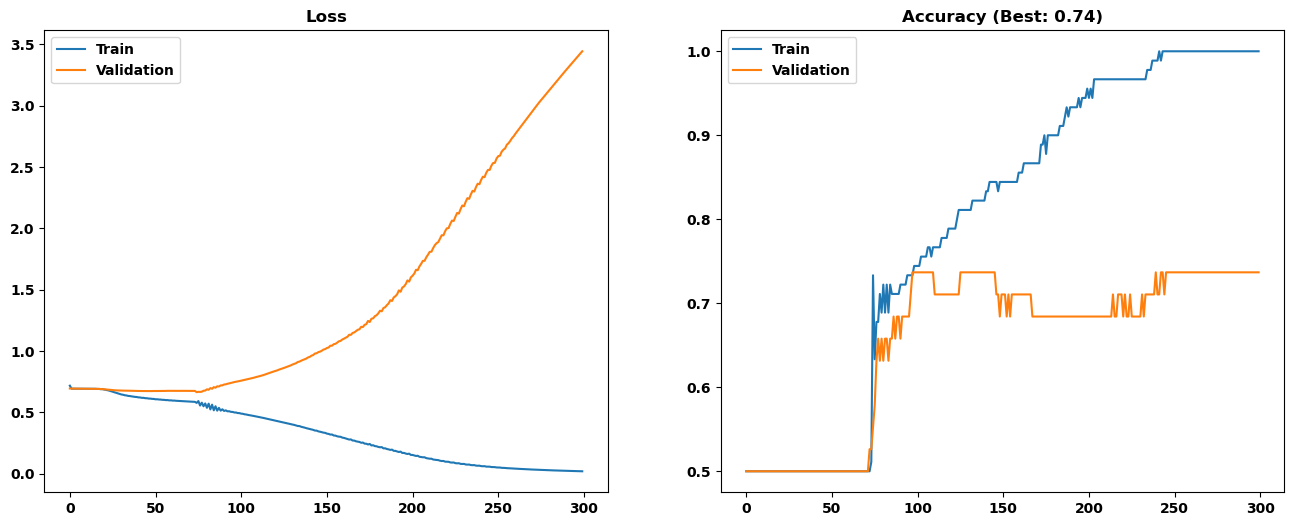

In [26]:
# data
np.random.seed(1)  
valsplit = 0.30
file_list =  prepare_file_list(path, valsplit)  
sample_sec = 2
batch_size = 8
data_loader = {tv: torch.utils.data.DataLoader(MSDataset(file_list[tv], sample_sec=sample_sec, is_train=tv=='train'),
                                               batch_size=batch_size,
                                               shuffle=False) for tv in ['train', 'val']}

# model
model = MyModel("ReLU").to(device)
num_params = get_num_trainable_parameters(model)

# optimizer
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# loss
criterion = nn.CrossEntropyLoss().to(device)

# history
history = None
if not skip_training:
    history = training_loop(300, optimizer, model, criterion, data_loader['train'], data_loader['val'], history)
    torch.save(model.state_dict(), 'model.pth')
    plot_history(history)

### Task 4.1: Experiment with normalization layers

Add a batch normalization layer after the convolution layer and before applying the non-linearity function. Train the model, monitor the behavior of the training and validation curves, and observe how the normalization layer affects the validation performance.

Save the model as **'normalized_model.pth'** and submit it to Moodle along with your other files.


In [28]:
class BasicBlock(nn.Module):
    # Define a convolutional block based on the base model:
    # - Add a batch normalization layer after the convolution layer and before the non-linearity function.
    # YOUR CODE HERE
    def __init__(self, in_channels, out_channels, nonlin="Tanh"):
        super().__init__()
        self.conv_layer = nn.Conv1d(in_channels=in_channels,
                                    out_channels=out_channels,
                                    kernel_size=11,
                                    stride=5)

        self.batch_normalize = nn.BatchNorm1d(out_channels)
        
        if nonlin == "ELU":
            self.activation_fn = nn.ELU()
        elif nonlin == "ReLU":
            self.activation_fn = nn.ReLU()
        elif nonlin == "Tanh":
            self.activation_fn = nn.Tanh()

    def forward(self, x):
        x = self.conv_layer(x)
        x = self.batch_normalize(x)
        x = self.activation_fn(x)
        return x
        
class MyModel(nn.Module):
    def __init__(self, nonlin ="Tanh"):
        super().__init__()
        
        # your code here for initializing layers
        # 1. Create the first hidden layer using BasicBlock
        #    - Input channels: 1 
        #    - Output channels: 128
        #    - Activation function: specified by 'nonlin'
        # 2. Create the second hidden layer using BasicBlock
        #    - Activation function: specified by 'nonlin'
        # 3. Create the third hidden layer using BasicBlock
        #    - Activation function: specified by 'nonlin'
        # 4. Create the forth hidden layer using BasicBlock
        #    - Input channels: 128 (from the output of the second layer)
        #    - Output channels: 2 (for the final output classes)
        #    - Activation function: specified by 'nonlin'
        # 5. Create a global average pooling layer to reduce the spatial dimensions
        # 6. Create a flattening layer to flatten the output for the final layer
        # 7. Set the output activation function for classification
        
        # YOUR CODE HERE
        self.Hidden_1 = BasicBlock(in_channels=1,
                                  out_channels=128,
                                  nonlin=nonlin)
        self.Hidden_2 = BasicBlock(in_channels=128,
                                  out_channels=128,
                                  nonlin=nonlin)
        self.Hidden_3 = BasicBlock(in_channels=128,
                                  out_channels=128,
                                  nonlin=nonlin)
        self.Hidden_4 = BasicBlock(in_channels=128,
                                  out_channels=2,
                                  nonlin=nonlin)

        self.pool = nn.AdaptiveAvgPool1d(1)
        self.flatten = nn.Flatten()
        self.activation = nn.LogSoftmax(dim=1)
       
    def forward(self, x):
        # your code here for calling layers
        # 1. Pass the input through the first hidden layer
        # 2. Pass the output to the second hidden layer
        # 3. Pass the output to the third hidden layer
        # 4. Pass the output to the forth hidden layer
        # 5. Apply global average pooling to reduce dimensions
        # 6. Flatten the pooled output
        # 7. Apply the output activation function to get the final predictions
        
        # YOUR CODE HERE
        conv1 = self.Hidden_1(x)
        conv2 = self.Hidden_2(conv1)
        conv3 = self.Hidden_3(conv2)
        conv4 = self.Hidden_4(conv3)

        pooled = self.pool(conv4)
        flattened = self.flatten(pooled)
        activated = self.activation(flattened)
        
        return activated

def get_num_trainable_parameters(model):
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'The model has {num_params} trainable parameters.')
    return num_params 

Run the cell below to verify the correctness of your model architecture solution.

In [29]:
# Visible tests here
all_tests_successful = True
model = MyModel("ReLU")
dummy_input = torch.randn(1, 1, 22000)

# Dictionary to hold the execution order of each BasicBlock's layers
layer_execution_order = {}
# Function to capture forward pass order of layers within each BasicBlock
def track_execution_order(module, input, output, name):
    layer_types = []
    for sub_module in module.children():  # Iterate through layers within BasicBlock
        layer_types.append(type(sub_module))
    layer_execution_order[name] = layer_types

# Register hooks on each BasicBlock to capture layer order in forward pass
for name, module in model.named_modules():
    if isinstance(module, BasicBlock):
        module.register_forward_hook(lambda mod, inp, out, n=name: track_execution_order(mod, inp, out, n))

# Run the model forward pass to trigger hooks
dummy_output = model(dummy_input)

# Define the expected order of layer types for BasicBlock
expected_order = [nn.Conv1d, nn.BatchNorm1d, nn.ReLU]  

# Check if each BasicBlock followed the expected order
for name, order in layer_execution_order.items():
    # Modify expected_order based on the chosen activation in model
    current_expected_order = expected_order[:]
    activation_fn_type = type(model.Hidden_1.activation_fn)  # Get the actual activation type
    current_expected_order[-1] = activation_fn_type
    
    if order != current_expected_order:
        all_tests_successful = False
        raise AssertionError(
            f"{name} layer order incorrect. Expected {[cls.__name__ for cls in current_expected_order]} "
            f"but got {[cls.__name__ for cls in order]}."
        )

# Check output shape and range for LogSoftmax
expected_shape = (1, 2)
if dummy_output.shape != expected_shape:
    all_tests_successful = False
    raise AssertionError(f"Expected output shape {expected_shape}, got {dummy_output.shape}.")
if not torch.all(dummy_output <= 0):
    all_tests_successful = False
    raise AssertionError("The output values are not within the expected range (-∞, 0]. LogSoftmax might be missing.")

# Final success message if all tests pass
if all_tests_successful:
    success_str = "Good job! All visible tests passed! You can proceed further."
    print(f"\033[92m{success_str}\033[0m")

Good job! All visible tests passed! You can proceed further.


### Train and Validate

Now, run the cell below to train and validate the model with the "ReLU" non-linearity, using Adam optimizer with lr = 0.0001.

Repeat the training several times and compare the results with the model without the normalization layers. . Do you observe any changed with the patterns of instability or overfitting? 

Remember to save the model as **'normalized_model.pth'** and submit it to Moodle along with your other files.


The model has 365830 trainable parameters.
Epoch 1, train_loss 0.70, train_accuracy: 0.4778, val_loss 0.69, val_accuracy: 0.5000, time = 5.23
Epoch 2, train_loss 0.81, train_accuracy: 0.3111, val_loss 0.71, val_accuracy: 0.5000, time = 5.31
Epoch 3, train_loss 0.70, train_accuracy: 0.5000, val_loss 0.70, val_accuracy: 0.5000, time = 4.98
Epoch 4, train_loss 0.69, train_accuracy: 0.5000, val_loss 0.69, val_accuracy: 0.5000, time = 4.93
Epoch 5, train_loss 0.69, train_accuracy: 0.5000, val_loss 0.69, val_accuracy: 0.5000, time = 5.27
Epoch 10, train_loss 0.69, train_accuracy: 0.5000, val_loss 0.69, val_accuracy: 0.5000, time = 5.19
Epoch 20, train_loss 0.69, train_accuracy: 0.5000, val_loss 0.69, val_accuracy: 0.5000, time = 5.3
Epoch 30, train_loss 0.67, train_accuracy: 0.5000, val_loss 0.68, val_accuracy: 0.5000, time = 6.98
Epoch 40, train_loss 0.64, train_accuracy: 0.5000, val_loss 0.67, val_accuracy: 0.5000, time = 3.41
Epoch 50, train_loss 0.61, train_accuracy: 0.5000, val_loss 0.6

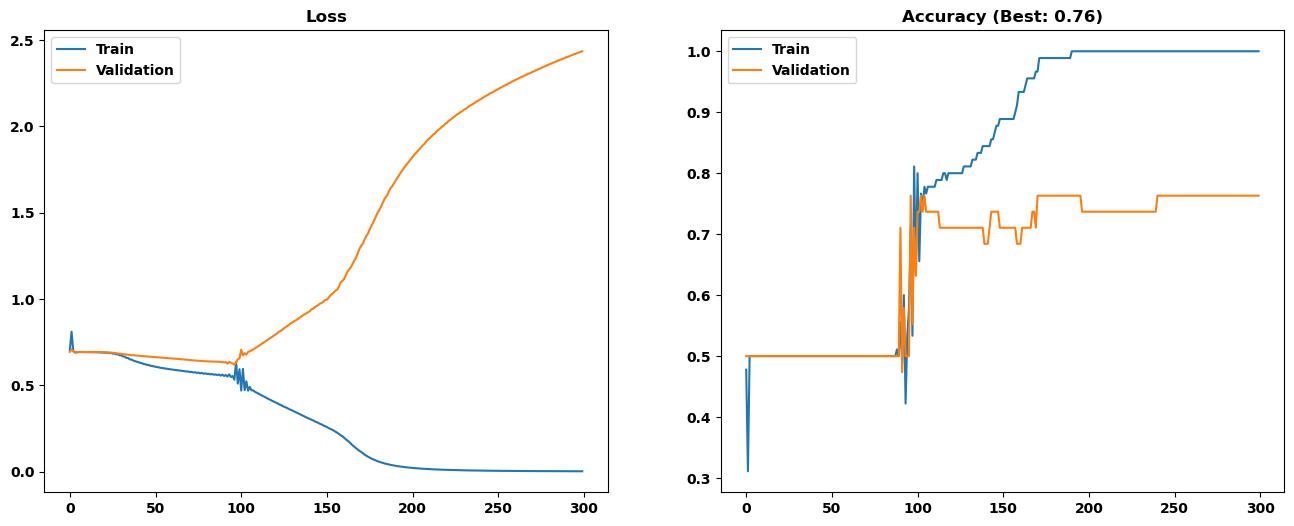

In [30]:
# data
np.random.seed(1)  
valsplit = 0.30
file_list =  prepare_file_list(path, valsplit)  
sample_sec = 2
batch_size = 8
data_loader = {tv: torch.utils.data.DataLoader(MSDataset(file_list[tv], sample_sec=sample_sec, is_train=tv=='train'),
                                               batch_size=batch_size,
                                               shuffle=False) for tv in ['train', 'val']}

# model
model = MyModel("ReLU").to(device)
num_params = get_num_trainable_parameters(model)

# optimizer
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# loss
criterion = nn.CrossEntropyLoss().to(device)

# history
history = None
if not skip_training:
    history = training_loop(300, optimizer, model, criterion, data_loader['train'], data_loader['val'], history)
    torch.save(model.state_dict(), 'normalized_model.pth')
    plot_history(history)

In [31]:
# Do not delete this cell

### Task 4.2: Experiment with dropout layers

Keep the normalization layers and add a dropout layer as the last layer of the convolutional block. 

Train the model, monitor the behavior of the training and validation curves, and observe how the dropout layers affects the validation performance.

In [32]:
class BasicBlock(nn.Module):
    # Define a convolutional block based on the base model:
    # - Add a batch normalization layer after the convolution layer and before the non-linearity function.
    # - Add a dropout layer with p=0.5 at the end of the block (after the non-linearity function).
    # YOUR CODE HERE
    def __init__(self, in_channels, out_channels, nonlin="Tanh"):
        super().__init__()
        self.conv_layer = nn.Conv1d(in_channels=in_channels,
                                    out_channels=out_channels,
                                    kernel_size=11,
                                    stride=5)

        self.batch_normalize = nn.BatchNorm1d(out_channels)
        
        if nonlin == "ELU":
            self.activation_fn = nn.ELU()
        elif nonlin == "ReLU":
            self.activation_fn = nn.ReLU()
        elif nonlin == "Tanh":
            self.activation_fn = nn.Tanh()

        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.conv_layer(x)
        x = self.batch_normalize(x)
        x = self.activation_fn(x)
        x = self.dropout(x)
        return x
        
class MyModel(nn.Module):
    def __init__(self, nonlin ="Tanh"):
        super().__init__()
        
        # your code here for initializing layers
        # 1. Create the first hidden layer using BasicBlock
        #    - Input channels: 1 
        #    - Output channels: 128
        #    - Activation function: specified by 'nonlin'
        # 2. Create the second hidden layer using BasicBlock
        #    - Activation function: specified by 'nonlin'
        # 3. Create the third hidden layer using BasicBlock
        #    - Activation function: specified by 'nonlin'
        # 4. Create the forth hidden layer using BasicBlock
        #    - Input channels: 128 (from the output of the second layer)
        #    - Output channels: 2 (for the final output classes)
        #    - Activation function: specified by 'nonlin'
        # 5. Create a global average pooling layer to reduce the spatial dimensions
        # 6. Create a flattening layer to flatten the output for the final layer
        # 7. Set the output activation function for classification
        
        # YOUR CODE HERE
        self.Hidden_1 = BasicBlock(in_channels=1,
                                  out_channels=128,
                                  nonlin=nonlin)
        self.Hidden_2 = BasicBlock(in_channels=128,
                                  out_channels=128,
                                  nonlin=nonlin)
        self.Hidden_3 = BasicBlock(in_channels=128,
                                  out_channels=128,
                                  nonlin=nonlin)
        self.Hidden_4 = BasicBlock(in_channels=128,
                                  out_channels=2,
                                  nonlin=nonlin)

        self.pool = nn.AdaptiveAvgPool1d(1)
        self.flatten = nn.Flatten()
        self.activation = nn.LogSoftmax(dim=1)
       
    def forward(self, x):
        # your code here for calling layers
        # 1. Pass the input through the first hidden layer
        # 2. Pass the output to the second hidden layer
        # 3. Pass the output to the third hidden layer
        # 4. Pass the output to the forth hidden layer
        # 5. Apply global average pooling to reduce dimensions
        # 6. Flatten the pooled output
        # 7. Apply the output activation function to get the final predictions
        
        # YOUR CODE HERE
        conv1 = self.Hidden_1(x)
        conv2 = self.Hidden_2(conv1)
        conv3 = self.Hidden_3(conv2)
        conv4 = self.Hidden_4(conv3)

        pooled = self.pool(conv4)
        flattened = self.flatten(pooled)
        activated = self.activation(flattened)
        
        return activated

def get_num_trainable_parameters(model):
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'The model has {num_params} trainable parameters.')
    return num_params 

Run the cell below to verify the correctness of your solution for the model architecture.

In [33]:
# Visible tests here
all_tests_successful = True
model = MyModel("ReLU")
dummy_input = torch.randn(1, 1, 22000)

# Dictionary to hold the execution order of each BasicBlock's layers
layer_execution_order = {}

# Function to capture forward pass order of layers within each BasicBlock
def track_execution_order(module, input, output, name):
    layer_types = []
    for sub_module in module.children():  # Iterate through layers within BasicBlock
        layer_types.append(type(sub_module))
    layer_execution_order[name] = layer_types

# Register hooks on each BasicBlock to capture layer order in forward pass
for name, module in model.named_modules():
    if isinstance(module, BasicBlock):
        module.register_forward_hook(lambda mod, inp, out, n=name: track_execution_order(mod, inp, out, n))

# Run the model forward pass to trigger hooks
dummy_output = model(dummy_input)

# Define the expected order of layer types for BasicBlock with Dropout
expected_order = [nn.Conv1d, nn.BatchNorm1d, nn.ReLU, nn.Dropout]  

# Check if each BasicBlock followed the expected order
for name, order in layer_execution_order.items():
    # Modify expected_order based on the chosen activation in model
    current_expected_order = expected_order[:]
    activation_fn_type = type(model.Hidden_1.activation_fn)  # Get the actual activation type
    current_expected_order[2] = activation_fn_type  # Ensure activation function is dynamically set

    if order != current_expected_order:
        all_tests_successful = False
        raise AssertionError(
            f"{name} layer order incorrect. Expected {[cls.__name__ for cls in current_expected_order]} "
            f"but got {[cls.__name__ for cls in order]}."
        )

# Check output shape and range for LogSoftmax
expected_shape = (1, 2)
if dummy_output.shape != expected_shape:
    all_tests_successful = False
    raise AssertionError(f"Expected output shape {expected_shape}, got {dummy_output.shape}.")
if not torch.all(dummy_output <= 0):
    all_tests_successful = False
    raise AssertionError("The output values are not within the expected range (-∞, 0]. LogSoftmax might be missing.")

# Final success message if all tests pass
if all_tests_successful:
    success_str = "Good job! All visible tests passed! You can proceed further."
    print(f"\033[92m{success_str}\033[0m")

Good job! All visible tests passed! You can proceed further.


### Train and Validate

Run the cell below to apply training and validation where the model is called with "ReLU" non-linearity. 

Repeat the training several times and compare the results with the model without the dropout layers. Do you observe any changed with the patterns of instability or overfitting?


The model has 365830 trainable parameters.
Epoch 1, train_loss 0.69, train_accuracy: 0.5111, val_loss 0.69, val_accuracy: 0.5000, time = 3.94
Epoch 2, train_loss 0.74, train_accuracy: 0.5000, val_loss 0.70, val_accuracy: 0.5000, time = 3.37
Epoch 3, train_loss 0.70, train_accuracy: 0.5000, val_loss 0.69, val_accuracy: 0.5000, time = 3.29
Epoch 4, train_loss 0.69, train_accuracy: 0.5000, val_loss 0.69, val_accuracy: 0.5000, time = 3.39
Epoch 5, train_loss 0.69, train_accuracy: 0.5000, val_loss 0.69, val_accuracy: 0.5000, time = 3.4
Epoch 10, train_loss 0.69, train_accuracy: 0.5000, val_loss 0.69, val_accuracy: 0.5000, time = 3.42
Epoch 20, train_loss 0.69, train_accuracy: 0.5000, val_loss 0.69, val_accuracy: 0.5000, time = 3.39
Epoch 30, train_loss 0.69, train_accuracy: 0.5000, val_loss 0.69, val_accuracy: 0.5000, time = 3.41
Epoch 40, train_loss 0.69, train_accuracy: 0.5000, val_loss 0.69, val_accuracy: 0.5000, time = 3.46
Epoch 50, train_loss 0.69, train_accuracy: 0.5000, val_loss 0.6

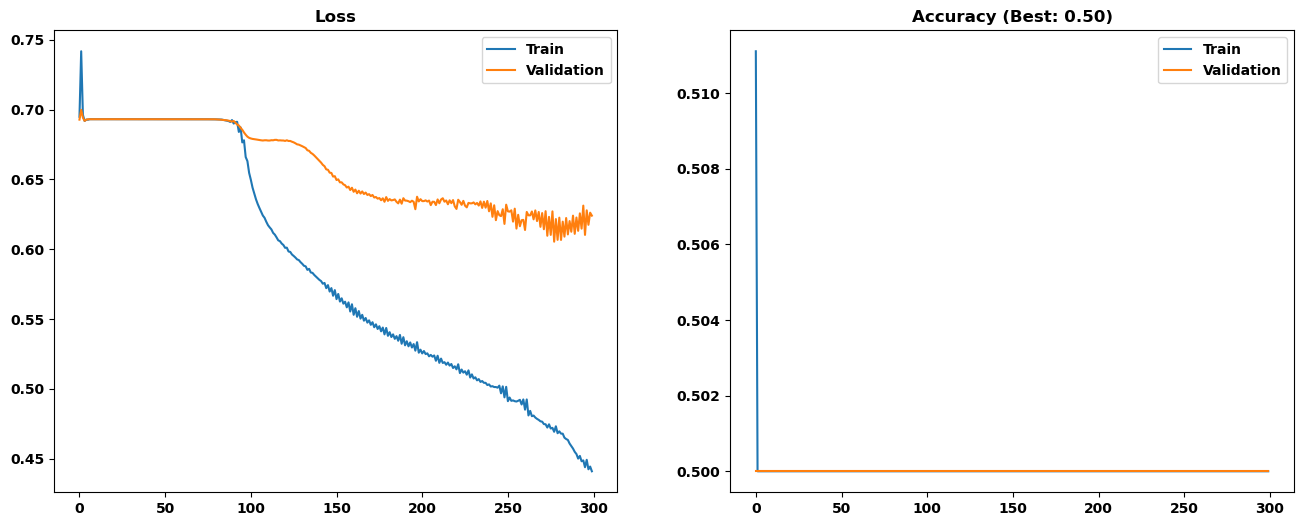

In [34]:
# data
np.random.seed(1)  
valsplit = 0.30
file_list =  prepare_file_list(path, valsplit)  
sample_sec = 2
batch_size = 8
data_loader = {tv: torch.utils.data.DataLoader(MSDataset(file_list[tv], sample_sec=sample_sec, is_train=tv=='train'),
                                               batch_size=batch_size,
                                               shuffle=False) for tv in ['train', 'val']}

# model
model = MyModel("ReLU").to(device)
num_params = get_num_trainable_parameters(model)

# optimizer
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# loss
criterion = nn.CrossEntropyLoss().to(device)

# history
history = None
if not skip_training:
    history = training_loop(300, optimizer, model, criterion, data_loader['train'], data_loader['val'], history)
    torch.save(model.state_dict(), 'model.pth')
    plot_history(history)

### Task 4.3: Experiment with efficient model architecture through pooling layers

As the final step, try to increase the model efficiency through a wiser design of the model architecture. In a deep learning model, while using a stack of convolutional blocks, it is common practice to use pooling layers between convolutional layers to decrease the dimension of the data and the resolution of deeper layers. This helps make the model lighter by reducing the number of trainable parameters and, at the same time, increases the model's performance by helping it focus on different feature types at different layers. For example, in the case of audio processing, the shallower layers can focus on finding variations in short time windows, while deeper layers can focus on detecting longer variations.

In this task, you are asked to follow the same logic and modify the model architecture using pooling layers.

Save the trained model as **'pooled_model.pth'** and submit it to Moodle along with your other files.

In the template prepared for the model architecture below, fill in the blanks as instructed.

In [12]:
class BasicBlock(nn.Module):
    # Define a convolutional block based on the base model:
    # - Add a batch normalization layer after the convolution layer and before the non-linearity function.
    # - Add a dropout layer with p=0.5 at the end of the block (after the non-linearity function). 
    # YOUR CODE HERE
    def __init__(self, in_channels, out_channels, kernel_size, stride, nonlin="Tanh"):
        super().__init__()
        self.conv_layer = nn.Conv1d(in_channels=in_channels,
                                    out_channels=out_channels,
                                    kernel_size=kernel_size,
                                    stride=stride)

        self.batch_normalize = nn.BatchNorm1d(out_channels)
        
        if nonlin == "ELU":
            self.activation_fn = nn.ELU()
        elif nonlin == "ReLU":
            self.activation_fn = nn.ReLU()
        elif nonlin == "Tanh":
            self.activation_fn = nn.Tanh()

        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.conv_layer(x)
        x = self.batch_normalize(x)
        x = self.activation_fn(x)
        x = self.dropout(x)
        return x
        
class MyModel(nn.Module):
    def __init__(self, nonlin ="Tanh"):
        super().__init__()        
         # your code here for initializing layers
        # 1. First hidden layer (BasicBlock)
        #    - Input channels: 1 (initial input channel for audio or speech data)
        #    - Output channels: 8
        #    - Activation function: specified by 'nonlin'
        #    - Kernel size: 22, Stride: 2
        # 2. Pooling layer after the first hidden layer
        #    - Type: MaxPool1d
        #    - Kernel size: 10 (to downsample the feature map)
        #    - Stride: 2
        # 3. Second hidden layer (BasicBlock)
        #    - Input channels: 8
        #    - Output channels: 16
        #    - Activation function: specified by 'nonlin'     
        #    - Kernel size: 22, Stride: 2
        # 4. Pooling layer after the second hidden layer
        #    - Type: MaxPool1d
        #    - Kernel size: 10
        #    - Stride: 2
        # 5. Third hidden layer (BasicBlock)
        #    - Input channels: 16
        #    - Output channels: 32
        #    - Activation function: specified by 'nonlin'        
        #    - Kernel size: 22, Stride: 2
        # 6. Global average pooling to reduce the output to a single value per channel     
        # 7. Flatten layer to prepare for fully connected output
        # 8. Fully connected layer to produce the final output with 'out_channels' classes
        #    (assuming 'out_channels' is set to the number of output classes) 
        # 9. Final output activation function (LogSoftmax) to get class probabilities in log space
        
        
        # YOUR CODE HERE
        self.Hidden_1 = BasicBlock(in_channels=1,
                                   out_channels=8,
                                   kernel_size=22,
                                   stride=2,
                                   nonlin=nonlin)
        self.Pool_1 = nn.MaxPool1d(kernel_size=10,
                                   stride=2)
        self.Hidden_2 = BasicBlock(in_channels=8,
                                   out_channels=16,
                                   kernel_size=22,
                                   stride=2,
                                   nonlin=nonlin)
        self.Pool_2 = nn.MaxPool1d(kernel_size=10,
                                   stride=2)
        self.Hidden_3 = BasicBlock(in_channels=16,
                                   out_channels=32,
                                   kernel_size=22,
                                   stride=2,
                                   nonlin=nonlin)
        self.GlobalPool = nn.AdaptiveAvgPool1d(1)
        self.Flatten = nn.Flatten()
        self.FullyConnected = nn.Linear(in_features=32,
                                        out_features=2)
        self.Activation = nn.LogSoftmax(dim=1)
       
    def forward(self, x):
        # your code here for forward pass through each layer     
        # Pass through the first hidden block and pooling layer     
        # Pass through the second hidden block and pooling layer
        # Pass through the third hidden block
        # Apply global average pooling to reduce each channel to a single value
        # Flatten the output for the fully connected layer
        # Pass through the fully connected layer
        # Apply the output activation to produce log-probabilities  
        # Apply the output activation to produce log-probabilities     
        # YOUR CODE HERE
        conv1 = self.Hidden_1(x)
        pooled1 = self.Pool_1(conv1)
        conv2 = self.Hidden_2(pooled1)
        pooled2 = self.Pool_2(conv2)
        conv3 = self.Hidden_3(pooled2)
        global_pooled = self.GlobalPool(conv3)
        flattened = self.Flatten(global_pooled)
        fully_connected = self.FullyConnected(flattened)
        activated = self.Activation(fully_connected)

        return activated

def get_num_trainable_parameters(model):
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'The model has {num_params} trainable parameters.')
    return num_params 

Run the cell below to verify the correctness of your solution for the model architecture.

In [13]:
# Visible tests here
all_tests_successful = True
model = MyModel("ReLU")
dummy_input = torch.randn(1, 1, 22000)
dummy_output = model(dummy_input)

# Count the number of Conv1d layers and check their channels
conv1d_layers = [layer for layer in model.modules() if isinstance(layer, nn.Conv1d)]
conv1d_count = len(conv1d_layers)

# Test the number of Conv1d layers
expected_conv_count = 3  # Number of Conv1d layers expected
if conv1d_count != expected_conv_count:
    all_tests_successful = False
    raise AssertionError(f"Expected {expected_conv_count} Conv1d layers, got {conv1d_count}.")

# Check expected output channels
expected_channels = [8, 16, 32]  # Expected output channels for the three Conv1d layers

for i, layer in enumerate(conv1d_layers):
    if layer.out_channels != expected_channels[i]:
        all_tests_successful = False
        raise AssertionError(f"Conv1d layer {i + 1} does not have {expected_channels[i]} filters (channels). It has {layer.out_channels} filters.")

# Check the output shape
expected_shape = (1, 2)  # Expected output shape
if dummy_output.shape != expected_shape:
    all_tests_successful = False
    raise AssertionError(f"Expected output shape {expected_shape}, but got {dummy_output.shape}.")

# Check the number of trainable parameters
def get_num_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

num_params = get_num_trainable_parameters(model)
expected_num_parameters = 14490  # Expected number of trainable parameters
if num_params != expected_num_parameters:
    all_tests_successful = False
    raise AssertionError(f"Expected number of trainable parameters {expected_num_parameters}, but got {num_params}.")

# Check the output range for LogSoftmax (should be <= 0)
if not torch.all(dummy_output <= 0):
    all_tests_successful = False
    raise AssertionError("The output values are not within the expected range (-∞, 0]. LogSoftmax might be missing.")

if all_tests_successful: 
    success_str = "Good job! All visible tests passed! You can proceed further."
    print(f"\033[92m{success_str}\033[0m")


Good job! All visible tests passed! You can proceed further.


### Train and Validate

Now, run the cell below to apply training and validation to your model. Remember to save the trained model as **'pooled_model.pth'** and submit it to Moodle along with your other files.

Compare the results with those from previously tested models. Observe how the hierarchical design of the convolutional blocks influences the model's performance on the training and validation splits. Additionally, take note of how this design impacts the number of trainable parameters and the overall training time.

In [ ]:
# data
np.random.seed(1)  
valsplit = 0.30
file_list =  prepare_file_list(path, valsplit)  
sample_sec = 2
batch_size = 8
data_loader = {tv: torch.utils.data.DataLoader(MSDataset(file_list[tv], sample_sec=sample_sec, is_train=tv=='train'),
                                               batch_size=batch_size,
                                               shuffle=False) for tv in ['train', 'val']}

# model
model = MyModel("ReLU").to(device)
get_num_trainable_parameters(model)

# optim
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# loss
criterion = nn.CrossEntropyLoss().to(device)

# history
history = None
if not skip_training:
    history = training_loop(300, optimizer, model, criterion, data_loader['train'], data_loader['val'], history)
    torch.save(model.state_dict(), 'pooled_model.pth')
    plot_history(history)

Epoch 1, train_loss 0.71, train_accuracy: 0.4556, val_loss 0.70, val_accuracy: 0.5000, time = 10.7
Epoch 2, train_loss 0.70, train_accuracy: 0.5000, val_loss 0.70, val_accuracy: 0.5000, time = 9.08
Epoch 3, train_loss 0.70, train_accuracy: 0.5000, val_loss 0.70, val_accuracy: 0.5000, time = 8.79
Epoch 4, train_loss 0.70, train_accuracy: 0.5000, val_loss 0.70, val_accuracy: 0.5000, time = 9.37
Epoch 5, train_loss 0.70, train_accuracy: 0.5000, val_loss 0.70, val_accuracy: 0.5000, time = 8.72
Epoch 10, train_loss 0.69, train_accuracy: 0.5000, val_loss 0.69, val_accuracy: 0.5000, time = 8.44
Epoch 20, train_loss 0.69, train_accuracy: 0.5000, val_loss 0.69, val_accuracy: 0.5000, time = 8.65
Epoch 30, train_loss 0.69, train_accuracy: 0.5000, val_loss 0.69, val_accuracy: 0.5000, time = 8.64


In [ ]:
# Visible tests for checking the performance of the trained model
all_tests_successful = True
if not skip_training:
    try:  
        # Test 1: Ensure training accuracy is within the correct range
        max_tacc = max(history['train_accuracy'])
        if not (0.5 <= max_tacc <= 1):
            all_tests_successful = False
            raise AssertionError(f"Training accuracy {max_tacc} is out of the expected range [0.7, 1].")
            
        # Test 2: Ensure accuracy is within the correct range
        max_vacc = max(history['val_accuracy'])
        if not (0.5 <= max_vacc <= 1):
            all_tests_successful = False
            raise AssertionError(f"Validation accuracy {max_vacc} is out of the expected range [0.7, 1].")
    
        if all_tests_successful:
            print(f"\033[92mAll visible tests for training and validation accuracy passed successfully!\033[0m")
    
    except AssertionError as e:
        print(f"\033[91mTest failed: {e}\033[0m")

else:
    print("This visible test is applicable only when `skip_training` is set to `False`.")

In [ ]:
# Do not delete this cell